In [1]:
import talib
import pandas as pd
import numpy as np
from dataProcess.DataClean import CDataClean
import matplotlib.pyplot as plt

In [2]:
CDC = CDataClean('/Users/Administrator/Desktop/pythonHistoricalTesting/data/USA30.IDXUSD_Candlestick_15_M_BID_15.04.2018-20.11.2020.csv')
df = CDC.TranslateCsvToDF_NotDropDuplicates()

def NewOpenBar(df):
    
    summer = ((df.GMT < '2018-11-04 02:00:00') | \
             ((df.GMT >= '2019-03-10 02:00:00') & (df.GMT < '2019-11-03 02:00:00')) | \
             ((df.GMT >= '2020-03-08 02:00:00') & (df.GMT < '2020-11-01 02:00:00'))).values
    
    df['SW'] = summer
    df['DayOfWeek'] = df.GMT.dt.dayofweek
    
    isOpenBar = []
    
    for gmt, sw, dow in zip(df.GMT, df.SW, df.DayOfWeek):
        
        if((sw == 1 and gmt.strftime('%H:%M:%S') == '13:30:00') or (sw == 0 and gmt.strftime('%H:%M:%S') == '14:30:00')):
            
            if(dow != 5 and dow != 6):
            
                isOpenBar.append('Open')
            
            else:
                
                isOpenBar.append(' ')
        
        else:
            
            isOpenBar.append(' ')
    
    df['IsOpenBar'] = isOpenBar
    
    return df

df = NewOpenBar(df)

newOpenBarList = df.loc[df.IsOpenBar == 'Open'].index.tolist()

rowInfo = []

for s, e in zip(newOpenBarList[:-1], newOpenBarList[1:]):

    data = df.loc[s:(e-1)]
    
    GMT = data.iloc[0].GMT
    Open = data.iloc[0].Open
    High = np.max(data.High)
    Low = np.min(data.Low)
    Close = data.iloc[-1].Close
    Volume = np.sum(data.Volume)

    rowInfo.append([GMT, Open, High, Low, Close, Volume])

df_D = pd.DataFrame(data=rowInfo, columns=['GMT','Open','High','Low','Close','Volume'])

#df = df_D.loc[df_D.Volume > 1e-6].reset_index(drop=True)

df = df_D.loc[df_D.Volume > 1e-6].reset_index(drop=True)

In [3]:
df['Range'] = df.High - df.Low
Date = []
for i in range(df.GMT.size):
    Date.append(df.loc[i].GMT.strftime('%Y-%m-%d'))

df['Date'] = Date

In [4]:
df.loc[df.Date == "2020-01-01"]#60 447 507  567   627  618 678

,GMT,Open,High,Low,Close,Volume,Range,Date
447,2020-01-01 14:30:00,28567.7,28708.1,28557.29,28642.87,3.977712e+06,150.81,2020-01-01


In [5]:
def CalcTargetBoundary(counts, bin_edges, targetPersentage=0.7):
    
    targetSum = np.sum(counts) * targetPersentage
    startPosition = np.argmax(counts)
    currentSum = np.max(counts)
    
    leftIdx = startPosition - 1
    rightIdx = startPosition + 1

    while currentSum < targetSum:

        if(leftIdx >= 0 and rightIdx >= 0):

            if(counts[leftIdx] > counts[rightIdx]):
                currentSum += counts[leftIdx]
                leftIdx -= 1

            else:
                currentSum += counts[rightIdx]
                rightIdx += 1

        if(leftIdx<0):
            currentSum += counts[rightIdx]
            rightIdx += 1

        if(rightIdx<0):
            currentSum += counts[leftIdx]
            leftIdx += 1 
    
    return ((bin_edges[leftIdx], bin_edges[rightIdx+1]))

In [6]:
def DataProcess4SMA1(df,a,b,sigma = 0):
    '''
    这个函数用于返回一个处理完的dataframe，新增Ratio,zscore和flag
    df为cam处理完的raw data
    a和b分别为需要研究的时间区间
    sigma表示去掉的异常值的标准 0：不去除 1：去除一倍标准差 2：去除两倍标准差
    默认滚20天为周期
    '''
    
    Ratio = [1]#先填充一个1
    
    for i in range(1,len(df.Range)):
        temp = df.Range[i]/df.Range[i - 1]
        Ratio.append(temp)
    df1 = df.copy()
    df1["Ratio"] = Ratio
    
    #判断当天是涨还是跌
    today_up_or_down_temp = (df1["Close"] - df1["Open"]).values.tolist()
    today_up_or_down = [1 if i >= 0 else 0 for i in today_up_or_down_temp]
    df1["today_up_or_down"] = today_up_or_down
        
    
    
    zscore = [1]*60
    for i in range(60,len(Ratio)):#剔除前60个值计算
        ratio_mean_sub = np.array(Ratio[(i-20):(i+1)]).mean()#向前滚20
        ratio_std_sub = np.array(Ratio[(i-20):(i+1)]).std()
        zscore_sub = (Ratio[i] - ratio_mean_sub)/ratio_std_sub
        zscore.append(zscore_sub)    
    df1['Z-score'] = zscore
    df1['Z-score_tomorrow'] = zscore[1:] + [1]
    
    #添加一个flag列
    flag = [0]   
    for i in range(len(zscore)-1):
        if abs(df1.High[i + 1] - df1.Close[i]) >= abs(df1.Low[i + 1] - df1.Close[i]):
            flag_temp = 1
        else:
            flag_temp = 0
        flag.append(flag_temp)
    
    df1["flag"] = flag
    df1["flag_tomorrow"] = flag[1:] + [1]
    
    counts, bin_edges = np.histogram(zscore[60:], bins=100)#注意zscore的前几个数是有问题的，切片时注意
    
    if sigma == 0:
        return df1  
    
    #如果需要去除outlier的话需执行下面的代码，且zscore要重新计算
    
    else:#sigma不为0的时候执行，也就是需要剔除标准差之外的来作图
        if sigma == 1:
            low, high = CalcTargetBoundary(counts, bin_edges, 0.6826)[0],CalcTargetBoundary(counts, bin_edges, 0.6826)[1]#一倍标准差的范围
        else:
            low, high = CalcTargetBoundary(counts, bin_edges, 0.9545)[0],CalcTargetBoundary(counts, bin_edges, 0.9545)[1]
            
        df_new = df1[a:b].loc[(df1["Z-score"]>= low)&(df1["Z-score"]<= high)].reset_index(drop = True)#剔除了一倍标准差或者两倍标准差的新的dataframe
        #剔除outlier后重新zscore
        zscore1 = [1]*20#前20个数没有
        for i in range(20,len(df_new)):
            ratio_mean_sub = np.array(df_new["Ratio"][(i-20):(i+1)]).mean()
            ratio_std_sub = np.array(df_new["Ratio"][(i-20):(i+1)]).std()
            zscore1_sub = (df_new["Ratio"][i] - ratio_mean_sub)/ratio_std_sub
            zscore1.append(zscore1_sub)
        df_new['Z-score'] = zscore1
        df_new['Z-score_tomorrow'] = zscore1[1:] + [1]
        df_new["flag_tomorrow"] = df_new['flag'][1:].tolist() + [1] #往前挪一格即可，后面缺位用1补 #####这里有点问题，做出来的flag_tomorrow不太对，应该是
        return df_new
    

In [7]:
test = DataProcess4SMA1(df,60,len(df),sigma = 0)
test[:61]

,GMT,Open,High,Low,Close,Volume,Range,Date,Ratio,today_up_or_down,Z-score,Z-score_tomorrow,flag,flag_tomorrow
0,2018-04-16 13:30:00,24525.070,24829.570,24485.169,24824.069,2.875840e+08,344.401,2018-04-16,1.000000,1,1.000000,1.000000,0,0
1,2018-04-17 13:30:00,24824.069,24860.169,24724.970,24793.569,3.087561e+08,135.199,2018-04-17,0.392563,0,1.000000,1.000000,0,0
2,2018-04-18 13:30:00,24793.569,24827.669,24656.069,24692.570,2.217600e+08,171.600,2018-04-18,1.269240,0,1.000000,1.000000,0,0
3,2018-04-19 13:30:00,24693.069,24757.670,24550.670,24658.070,3.405954e+08,207.000,2018-04-19,1.206294,0,1.000000,1.000000,0,0
4,2018-04-20 13:30:00,24658.570,24679.170,24373.670,24513.570,3.986900e+08,305.500,2018-04-20,1.475845,0,1.000000,1.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2018-07-03 13:30:00,24414.070,24444.670,24144.469,24241.470,3.322155e+08,300.201,2018-07-03,0.768957,0,1.000000,1.000000,0,1
57,2018-07-04 13:30:00,24240.970,24374.569,24126.970,24318.569,2.975199e+08,247.599,2018-07-04,0.824777,1,1.000000,1.000000,1,0
58,2018-07-05 13:30:00,24318.569,24434.469,24172.669,24330.070,5.020943e+08,261.800,2018-07-05,1.057355,1,1.000000,1.000000,0,1
59,2018-07-06 13:30:00,24330.069,24611.469,24279.670,24577.070,4.070334e+08,331.799,2018-07-06,1.267376,1,1.000000,-0.334083,1,1


In [8]:
#test["Z-score"]
def averageLine4Zscore(T,df):
    avg = [0] * (60 + T)
    for i in range(60 + T,len(df)):
        avg_sub = df[i-T:(i + 1)]["Z-score"].mean()
        avg.append(avg_sub)
    new_df = df.copy()
    new_df['avg_line'] = avg
    return new_df

In [9]:
avg20 = averageLine4Zscore(20,test)[81:]
avg40 = averageLine4Zscore(40,test)[121:]
avg60 = averageLine4Zscore(60,test)[121:]

In [1]:
# fig = plt.figure(figsize = (90,8))
# ax = fig.add_subplot(111)
# ax.plot(avg20["Date"],avg20['avg_line'],color = 'red')
# ax.plot(avg40["Date"],avg40['avg_line'],color = 'green')
# ax.plot(avg60["Date"],avg60['avg_line'],color = 'blue')
# plt.xticks(rotation=90)
# plt.title("avg_line red:20 green:40 blue:60")
# ax1 = ax.twinx()
# ax1.plot(avg20["Date"],avg20['Z-score'],color = 'black',alpha = 0.5)
# ax1.legend('Z-score')
# plt.savefig('./avg_line.jpg')

In [11]:
def drawAVGLine(T,df):
    
    
    #plt.plot(df["Date"],df['Z-score'])
    #plt.xticks(rotation=90)
    fig = plt.figure(figsize = (90,8))
    ax = fig.add_subplot(111)
    ax.plot(df["Date"],df['avg_line'])
    ax.legend('avg')
    plt.xticks(rotation=90)
    plt.title("avg {}".format(T))
    ax1 = ax.twinx()
    ax1.scatter(df["Date"],df['Z-score'])
    ax1.legend('Z-score')
    plt.savefig('./avg {}.jpg'.format(T))

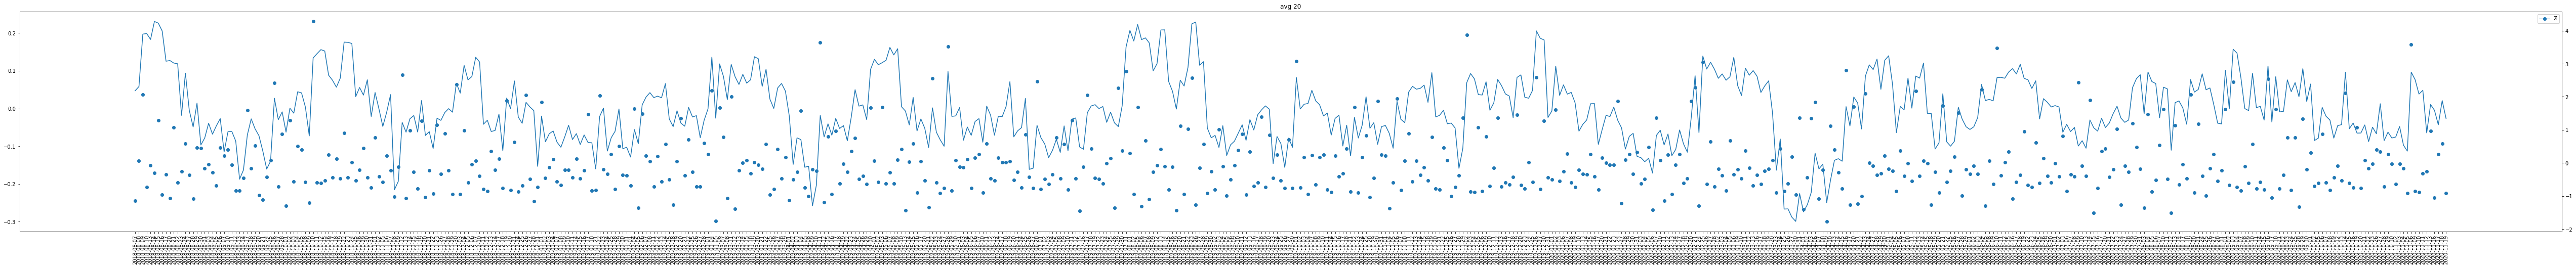

In [12]:
drawAVGLine(20,avg20)

In [13]:
#输入原始dataframe
#计算zscore
#计算flag
'''
定义每一个zscore的区间类别：
A：-1以下 
B：-1到-0.5 
C：-0.5到0 
D：0到0.5 
E：0.5到1 
F：1到2
G：2以上

然后把对应的当天的zscore区间类别做group by 去统计mean和median
再单独统计当天1以上的方向性
'''

def AddTags(df,judge):
    '''
    judge = 1 表示输入的df剔除了异常值 = 0 表示未剔除异常值
    '''
    #对df中的数据列打标签tag
    if judge == 0:
        tag = [1] * 60
        for i in range(60,len(df)):
            if df.iloc[i]['Z-score'] >= float(2):
                tag_sub = 'G'
            elif df.iloc[i]['Z-score'] >= float(1):
                tag_sub = 'F'
            elif df.iloc[i]['Z-score'] >= float(0.5):
                tag_sub = 'E'
            elif df.iloc[i]['Z-score'] >= float(0):
                tag_sub = 'D'
            elif df.iloc[i]['Z-score'] >= float(-0.5):
                tag_sub = 'C'
            elif df.iloc[i]['Z-score'] >= float(-1):
                tag_sub = 'B'
            else:
                tag_sub = 'A'
            tag.append(tag_sub)
            
        tag_tomorrow = tag[1:] + [1]
        
        
    else:
        tag = [1] * 20     
        for i in range(20,len(df)):
            if df.iloc[i]['Z-score'] >= float(2):
                tag_sub = 'G'
            elif df.iloc[i]['Z-score'] >= float(1):
                tag_sub = 'F'
            elif df.iloc[i]['Z-score'] >= float(0.5):
                tag_sub = 'E'
            elif df.iloc[i]['Z-score'] >= float(0):
                tag_sub = 'D'
            elif df.iloc[i]['Z-score'] >= float(-0.5):
                tag_sub = 'C'
            elif df.iloc[i]['Z-score'] >= float(-1):
                tag_sub = 'B'
            else:
                tag_sub = 'A'
            tag.append(tag_sub)
        tag_tomorrow = tag[1:] + [1]
        
    df['tag'] = tag
    df['tag_tomorrow'] = tag_tomorrow
    return df

In [14]:
final = AddTags(test,0)[60:677]
final

,GMT,Open,High,Low,Close,Volume,Range,Date,Ratio,today_up_or_down,Z-score,Z-score_tomorrow,flag,flag_tomorrow,tag,tag_tomorrow
60,2018-07-09 13:30:00,24577.070,24889.970,24575.069,24849.070,1.985530e+08,314.901,2018-07-09,0.949072,1,-0.334083,-0.166868,1,0,C,C
61,2018-07-10 13:30:00,24851.070,24944.670,24616.969,24719.069,1.846826e+08,327.701,2018-07-10,1.040648,0,-0.166868,-0.848479,0,1,C,B
62,2018-07-11 13:30:00,24722.070,24911.070,24659.669,24900.069,1.062365e+08,251.401,2018-07-11,0.767166,1,-0.848479,-0.757451,1,1,B,B
63,2018-07-12 13:30:00,24902.569,25008.469,24811.669,24922.569,1.007841e+08,196.800,2018-07-12,0.782813,1,-0.757451,0.262868,1,1,B,D
64,2018-07-13 13:30:00,24923.069,25103.970,24887.670,25034.069,8.059843e+07,216.300,2018-07-13,1.099085,1,0.262868,-1.308225,1,1,D,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,2020-11-11 14:30:00,29588.049,29593.997,29088.509,29201.529,1.918005e+07,505.488,2020-11-11,0.943008,0,-0.321573,-0.257602,0,0,C,C
673,2020-11-12 14:30:00,29201.519,29368.089,28899.227,29264.069,3.004156e+07,468.862,2020-11-12,0.927543,1,-0.257602,0.971586,0,1,C,E
674,2020-11-13 14:30:00,29264.057,30072.799,29210.699,29897.049,2.695476e+07,862.100,2020-11-13,1.838707,1,0.971586,-1.056009,1,0,E,A
675,2020-11-16 14:30:00,29897.087,29981.279,29645.559,29696.019,2.423856e+07,335.720,2020-11-16,0.389421,0,-1.056009,0.260394,0,1,A,D


In [15]:
#做概率统计的groupby
test1 = final[['tag','tag_tomorrow','Z-score_tomorrow']].groupby(['tag','tag_tomorrow']).mean()

In [17]:
test1.loc['A'].loc['B'].values[0]

-0.6457534407581065

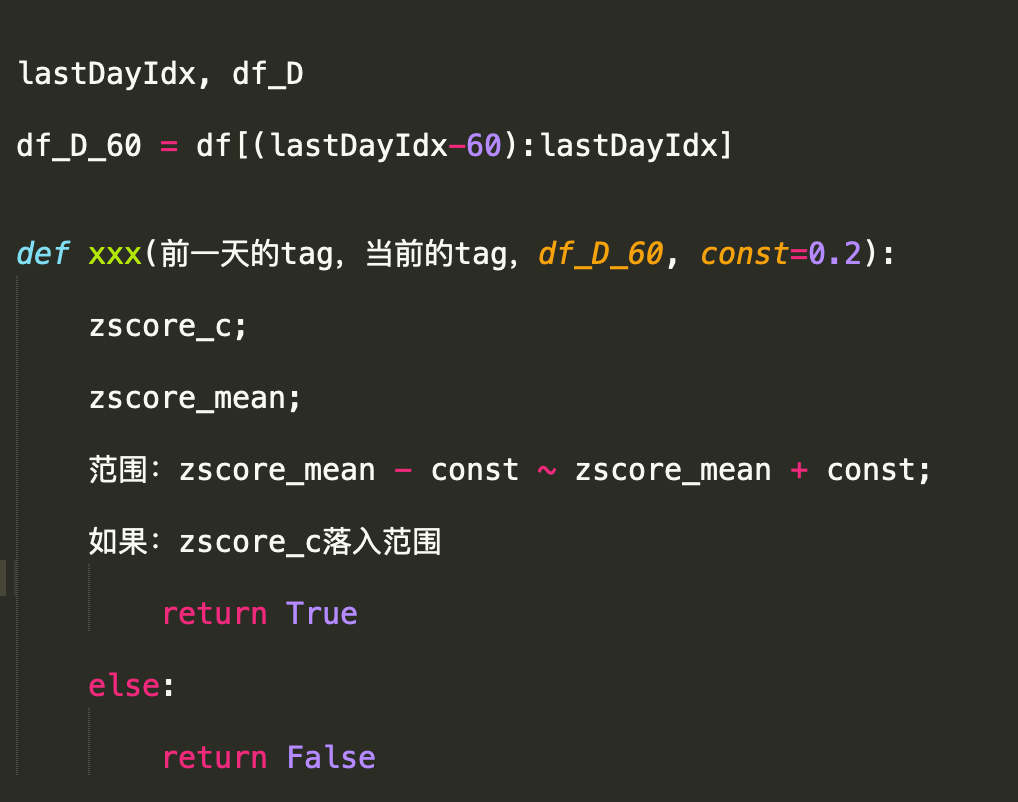

In [18]:
def getRange4today_s_zscore(tag_yesterday,current_tag,zscore_c,df,const = 0.2):
    df_filered = df[['tag','tag_tomorrow','Z-score_tomorrow']].groupby(['tag','tag_tomorrow']).mean()
    mean = df_filtered.loc['tag_yesterday'].loc['current_tag'].values[0]
    sub,sup = mean - const,mean + const
    if (zscore_c >= sub) & (zscore_c <= sup):
        return True
    else:
        return False

In [19]:
#做方向性，选择zscore在1以上的，也就是tag为F和G的
zscore_1 = final.loc[(final["tag"] == "F")|(final["tag"] == "G")]["Date"].tolist()
zscore_minus_05 = final.loc[(final["tag"] == "A")|(final["tag"] == "B")]["Date"].tolist()

In [2]:
zscore_normal = final.loc[(final["tag"] == "C")|(final["tag"] == "D")|(final["tag"] == "E")]["Date"].tolist()
# zscore_normal

NameError: name 'final' is not defined

In [22]:
#result.to_csv("direction.csv")

## 以下为寻找对应的日期的flag和flag_tomorrow

In [25]:
searchTable = DataProcess4SMA1(df,60,len(df),sigma = 0)
Date = []
flag = []
flag_tomorrow = []
Trend_table_for_today_and_tomorrow = pd.DataFrame()
for i in zscore_minus_05:
    Date.append(i)
    flag_sub,flag_tomorrow_sub = searchTable.loc[searchTable.Date == i]['flag'].values[0],searchTable.loc[searchTable.Date == i]['flag_tomorrow'].values[0]
    flag.append(flag_sub)
    flag_tomorrow.append(flag_tomorrow_sub)
Trend_table_for_today_and_tomorrow["Date"] = Date
Trend_table_for_today_and_tomorrow["flag"] = flag
Trend_table_for_today_and_tomorrow["flag_tomorrow"] = flag_tomorrow

In [26]:
Trend_table_for_today_and_tomorrow

,Date,flag,flag_tomorrow
0,2018-07-11,1,1
1,2018-07-12,1,1
2,2018-07-16,1,1
3,2018-07-18,1,0
4,2018-07-20,1,1
...,...,...,...
216,2020-11-02,1,1
217,2020-11-05,1,1
218,2020-11-09,0,1
219,2020-11-10,1,0


In [27]:
Trend_table_for_today_and_tomorrow.to_csv("Trend_table_for_today_and_tomorrow.csv")